In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt


If token is not manually uploaded in the first place...
```
from google.colab import files
files.upload() #upload kaggle.json
```
Install Kaggle, auth, then download dataset
```
# Install Kaggle from PyPI
!pip install -q kaggle

# Kaggle: auth
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
 
# Download and unpack dataset
!kaggle datasets download -d crawford/emnist
!unzip emnist.zip
```

In [ ]:
class ResidualBlock(keras.layers.Layer):

    def __init__(self, n_filters=64, kernel_regularizer=None, down_sampling=False):
        ## Gọi hàm khởi tạo của keras.layers.Layer và lưu lại các thông số
        super(ResidualBlock, self).__init__()
        self.n_filters = n_filters
        self.down_sampling = down_sampling
        self.kernel_regularizer = kernel_regularizer
    
    ## override hàm này để có thể lưu file
    def get_config(self):
        ## lấy config của lớp cha
        config = super(ResidualBlock, self).get_config()
        ## thêm config của lớp này
        config.update({
            'n_filters': self.n_filters,
            "down_sampling": self.down_sampling,
        })
        return config
    
    def build(self, input_shape):
        
        ## Xác định xem input_shape có bằng output_shape không
        self.projection_shortcut = (int(input_shape[-1]) != self.n_filters) or self.down_sampling
        
        ## Nếu cần down sampling thì convolutional layer đầu tiên dùng strides=[2,2]
        first_strides = [1,1]
        if self.down_sampling:
            first_strides = [2,2]
        
        ##Khai báo các layer nhánh chính
        self.main_conv1 = Convolution2D(filters=self.n_filters,
                                         kernel_size=[3,3],
                                         strides=first_strides,
                                         padding='same',
                                         kernel_regularizer=self.kernel_regularizer,
                                         activation=None)
        self.main_batch1 = BatchNormalization()
        self.main_relu1 = ReLU()

        self.main_conv2 = Convolution2D(filters=self.n_filters,
                                              kernel_size=[3,3],
                                              strides=[1,1],
                                              padding='same',
                                              kernel_regularizer=self.kernel_regularizer,
                                              activation=None)
        self.main_batch2 = BatchNormalization()
        
        ## Khai báo các layer nhánh shortcut
        if self.projection_shortcut:
            self.shortcut_conv = Convolution2D(filters=self.n_filters,              ### N_FILETERS bằng N_FILTERS của output
                                                        kernel_size=[1,1],          ### KERNEL_SIZE = [1,1]
                                                        strides=first_strides,      ### STRIDES: giống STRIDES của conv đầu
                                                        padding='same',
                                                        kernel_regularizer=self.kernel_regularizer,
                                                        activation=None)
            self.shortcut_batch = BatchNormalization()

        self.main_relu2 = ReLU()

    def call(self, inputs):
        
        ## Thiết lập các input cho các layer đã khai báo
        main_conv1 = self.main_conv1(inputs)
        main_batch1 = self.main_batch1(main_conv1)
        main_relu1 = self.main_relu1(main_batch1)
        
        main_conv2 = self.main_conv2(main_relu1)
        main_batch2 = self.main_batch2(main_conv2)

        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_batch = self.shortcut_batch(shortcut_conv)
            
            ## Nếu input_shape != output_shape thì shortcut là convolutional layer
            shortcut = shortcut_batch
        else:
            ## Nếu input_shape == output_shape thì shortcut là inputs
            shortcut = inputs

        main_add = main_batch2 + shortcut

        main_relu2 = self.main_relu2(main_add)
        return main_relu2

In [ ]:
from keras.regularizers import l2
l2_regularizer_rate = 1e-5

## Tạo lớp input kích thước (None, 28, 28, 1)
inputs = keras.layers.Input(shape=(28,28,1))

### Block 1
conv1 = Convolution2D(filters=64,
                      kernel_size=[7,7],
                      strides=[2,2],
                      padding='same',
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(inputs)

batch1 = BatchNormalization()(conv1)        ## lớp tf.keras.layers.BatchNormalization()

relu1 = ReLU()(batch1)

maxpool1 = MaxPool2D(pool_size=[3,3],
                     strides=[2,2])(relu1)

### Block 2

res2_1 = ResidualBlock(n_filters=64,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(maxpool1)
res2_2 = ResidualBlock(n_filters=64,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_1)
res2_3 = ResidualBlock(n_filters=64,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_2)

### Block 3

res3_1 = ResidualBlock(n_filters=128,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_3)
res3_2 = ResidualBlock(n_filters=128,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_1)
res3_3 = ResidualBlock(n_filters=128,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_2)
res3_4 = ResidualBlock(n_filters=128,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_3)

### Block 4

res4_1 = ResidualBlock(n_filters=256,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_4)
res4_2 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_1)
res4_3 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_2)
res4_4 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_3)
res4_5 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_4)
res4_6 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_5)

### Block 5

res5_1 = ResidualBlock(n_filters=512,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_6)
res5_2 = ResidualBlock(n_filters=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_1)
res5_3 = ResidualBlock(n_filters=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_2)


### Block Output

avage_pool = GlobalAveragePooling2D()(res5_3)
softmax = Dense(units=47, activation='softmax')(avage_pool)


In [ ]:
train = pd.read_csv("emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [ ]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
del train

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
del test

In [ ]:
# number of classes
num_classes = y_train.nunique()
print(num_classes)
# One hot encoding / Create label for Multi label Classification
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print("train_y: ", y_train.shape)
print("test_y: ", y_test.shape)

47
train_y:  (112799, 47)
test_y:  (18799, 47)


In [ ]:
### Plot ảnh đã processing
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# X_train, X_test = X_train/255.0, X_test/255.0
# for i in range(100, 109):
#     plt.subplot(330 + (i+1))
#     plt.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))

In [ ]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [ ]:
# Flip and rotate image
X_train = np.asarray(X_train)
X_train = np.apply_along_axis(rotate, 1, X_train)
print ("train_x:",X_train.shape)

X_test = np.asarray(X_test)
X_test = np.apply_along_axis(rotate, 1, X_test)
print ("test_x:",X_test.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [ ]:
X_train, X_test = X_train/255.0, X_test/255.0

In [ ]:

# for i in range(100, 109):
#     plt.subplot(330 + (i+1))
#     plt.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))

In [ ]:
import cv2
X_train = np.array([cv2.resize(img, dsize=(28,28)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize=(28,28)) for img in X_test])

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print ("train_x:",X_train.shape)
print ("test_x:",X_test.shape)
#Valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

train_x: (112799, 28, 28, 1)
test_x: (18799, 28, 28, 1)


In [ ]:
# ### Compile model
from keras import optimizers, callbacks
opt = optimizers.Adam(learning_rate=1e-5)
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3200      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
residual_block_48 (ResidualB (None, 6, 6, 64)          74368     
_________________________________________________________________
residual_block_49 (ResidualB (None, 6, 6, 64)         

In [ ]:
#call back
callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                                   mode='max', 
                                   verbose = 1,
                                   restore_best_weights=True)

mc = callbacks.ModelCheckpoint(filepath="resnet34_mnist.h5",
                                     monitor='val_loss',
                                     mode='min',
                                     verbose=0,
                                     save_best_only=True,
                                     )

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks = [mc])

In [ ]:
model.save('ResNet34_model.h5')

In [ ]:
# y_pred = model.predict(X_test)
# for i, each in enumerate(y_pred):
#   temp = np.zeros(47)
#   index = np.argmax(y_pred[i])
#   y_pred[i] = temp
#   y_pred[i][index]+=1

In [ ]:
### Xuất ra những hình bị sai predict
# f = plt.figure(figsize=(12,4))
# n = -1
# for i in range(y_test.shape[0]):
#   if (y_test[i] != y_pred[i]).any() and n < 29 and np.count_nonzero(y_pred[i]) != 0:
#     n += 1
#     sp = f.add_subplot(3, 10, n+1)
#     sp.axis('Off')
#     sp.set_title(chr(mapp[np.where(y_pred[i]==True)[0][0]]) + " | " +  chr(mapp[np.where(y_test[i] == True)[0][0]]))
#     plt.imshow(X_test[i].reshape((28,28)), cmap=plt.get_cmap('gray'))
#     if n == 30:
#       print(i)
#       f = plt.figure(figsize=(12,4))
#       break
# import keras
# from keras.datasets import mnist

# import numpy as np
# from PIL import Image, ImageOps
# import os

# def save_image(filename, data_array):
#     im = Image.fromarray(data_array.astype('uint8'))
#     im_invert = ImageOps.invert(im)
#     im_invert.save(filename)

# DIR_NAME = "JPEGImages"
# if os.path.exists(DIR_NAME) == False:
#     os.mkdir(DIR_NAME)

# # Save Images
# i = 0
# for i in range(y_test.shape[0]):
#   if (y_test[i] != y_pred[i]).any() and np.count_nonzero(y_pred[i]) != 0:
#     print("[---------------------------------------------------------------]")
#     if os.path.exists(f'{DIR_NAME}/{chr(mapp[np.where(y_test[i] == True)[0][0]])}') == False:
#       os.mkdir(f'{DIR_NAME}/{chr(mapp[np.where(y_test[i] == True)[0][0]])}')
#     filename = "{0}/{3}/{1:05d}_{2}.jpg".format(DIR_NAME,i,chr(mapp[np.where(y_pred[i]==True)[0][0]]),chr(mapp[np.where(y_test[i] == True)[0][0]]))
#     print(filename)
#     save_image(filename, X_test[i].reshape((28,28))*255)
#     i += 1

In [ ]:
### Zip folder chứa hình bị sai predict
# !zip -r /content/file.zip /content/JPEGImages/
# from google.colab import files
# files.download("/content/file.zip")

Confusion matrix, without normalization
[[227   0   0 ...   0   0   0]
 [  0 198   1 ...   0   0   1]
 [  0   0 339 ...   5   0   0]
 ...
 [  0   1   4 ... 157   0   5]
 [  1   1   0 ...   0 369   5]
 [  0   1   0 ...   0   4 343]]
Normalized confusion matrix
[[0.57 0.   0.   ... 0.   0.   0.  ]
 [0.   0.49 0.   ... 0.   0.   0.  ]
 [0.   0.   0.85 ... 0.01 0.   0.  ]
 ...
 [0.   0.   0.01 ... 0.39 0.   0.01]
 [0.   0.   0.   ... 0.   0.92 0.01]
 [0.   0.   0.   ... 0.   0.01 0.86]]


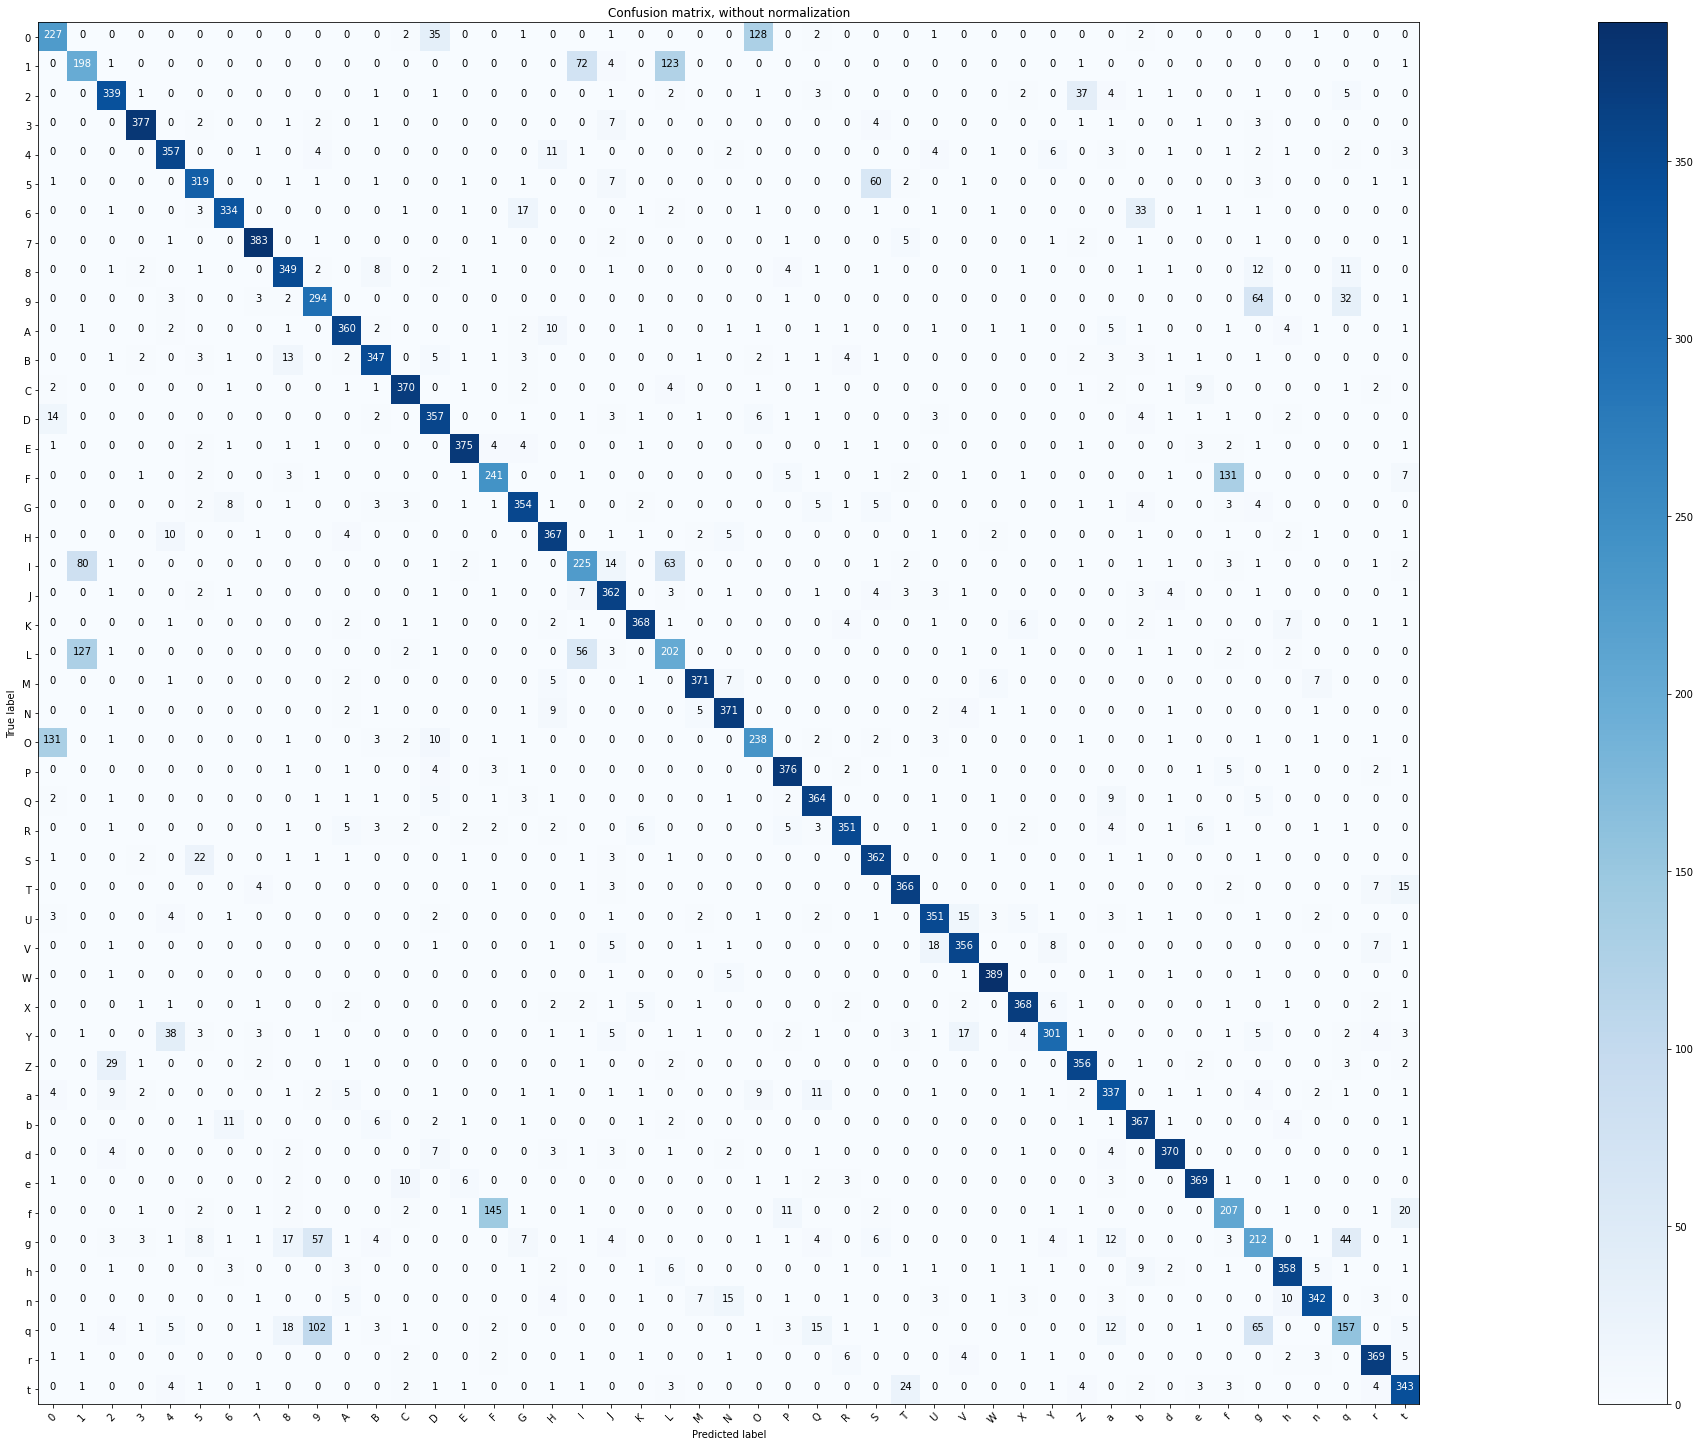

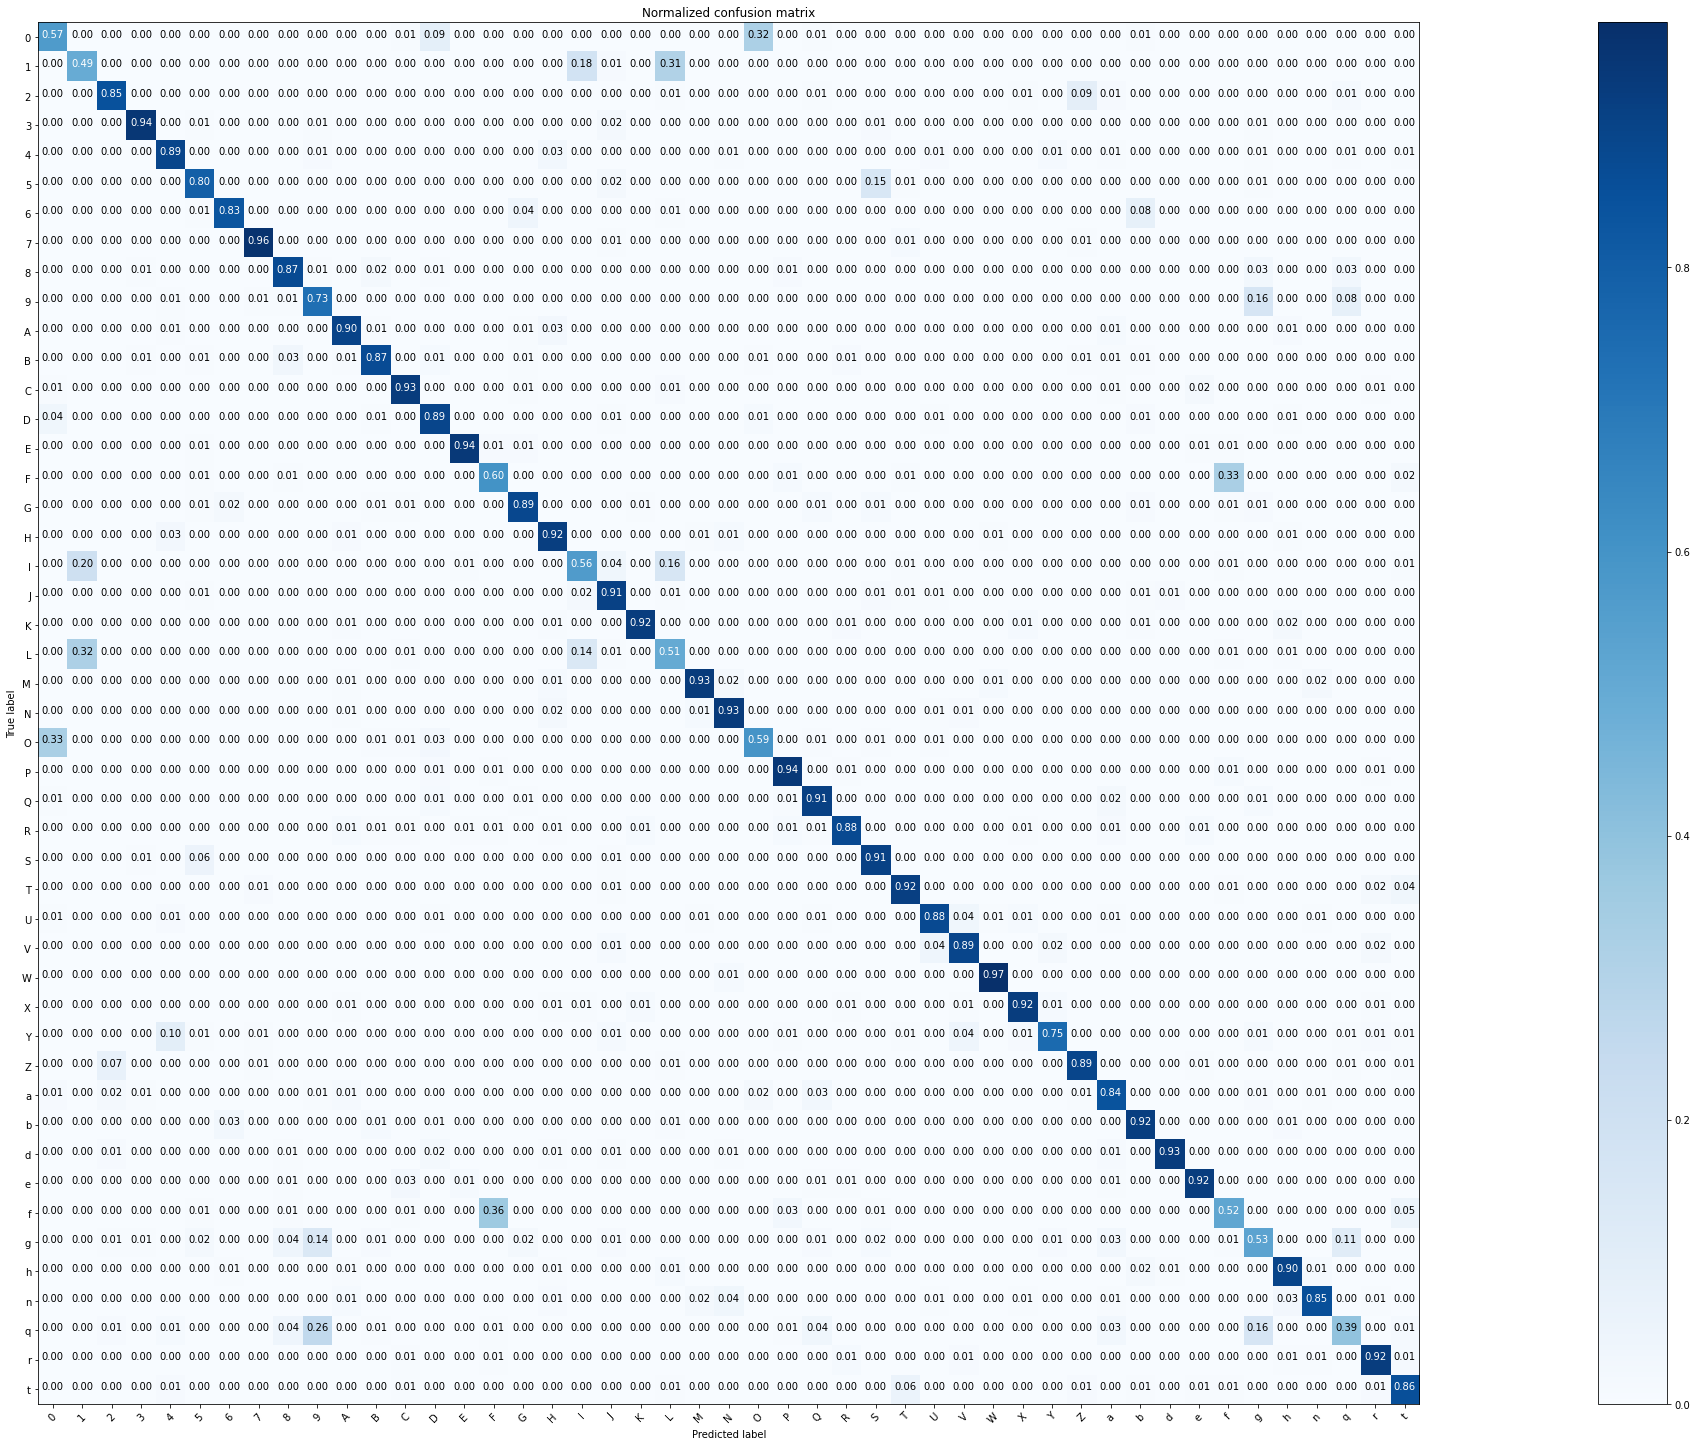

In [ ]:
### Confusion matrix
# from sklearn import metrics
# cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
# import itertools
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')


# class_names = [chr(mapp[i]) for i in range(num_classes)]
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure(figsize=(50,20))
# plot_confusion_matrix(cm, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure(figsize=(50,20))
# plot_confusion_matrix(cm, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [ ]:
### Download model
# from google.colab import files
# files.download("/content/ResNet34_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ## Test 1 trường hợp
# sample_0 = X_test[0]
# sample_0 = sample_0.reshape(1,28,28,1)
# label_sample_0 = model.predict(sample_0)
# print(label_sample_0)

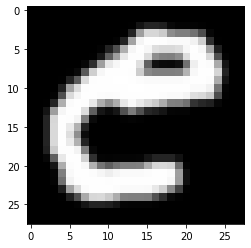

In [ ]:
# plt.imshow(sample_0.reshape(28,28), cmap=plt.get_cmap('gray'))

In [ ]:
# real_label_sample_0 = y_test[0]
# temp = np.zeros(47)
# index = np.argmax(label_sample_0)
# temp[index]+=1
# label_sample_0 = temp
# print(real_label_sample_0)
# print(label_sample_0)

In [ ]:
# print("label_predict : ",chr(mapp[index]))
# print("real_label : ",chr(mapp[np.argmax(real_label_sample_0)]))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


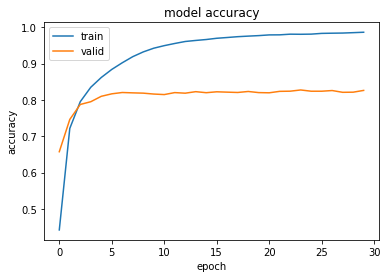

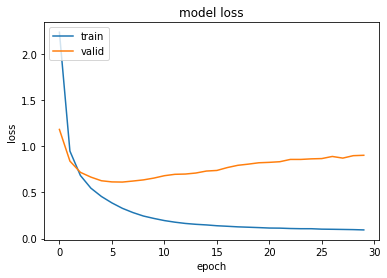

In [ ]:
### Graph biểu diễn sự biến thiên khi train
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')
# plt.savefig('acc_basic.png')

# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')
# plt.savefig('loss_basic.png')
# plt.show()